<a href="https://colab.research.google.com/github/Nada-Elghaweet/Ai-safety-system/blob/Randomforest_IMGS/RandomForestModell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()
zip_name = 'VIOLENCE VS NON_VIOLENCE.zip'
extract_path = 'dataset'

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path))


Saving VIOLENCE VS NON_VIOLENCE.zip to VIOLENCE VS NON_VIOLENCE (1).zip
['VIOLENCE VS NON_VIOLENCE']


In [13]:
import glob

DATA_DIR = 'dataset/VIOLENCE VS NON_VIOLENCE'
CLASSES = sorted(os.listdir(os.path.join(DATA_DIR, 'train')))
print("Classes:", CLASSES)

def get_image_paths_labels(split):
    X_paths, y_labels = [], []
    for label, cls in enumerate(CLASSES):
        folder = os.path.join(DATA_DIR, split, cls)
        for img_path in glob.glob(os.path.join(folder, '*')):
            X_paths.append(img_path)
            y_labels.append(label)
    return X_paths, y_labels


X_train_paths, y_train = get_image_paths_labels('train')
X_val_paths, y_val = get_image_paths_labels('val')
X_test_paths, y_test = get_image_paths_labels('test')

print(f"Train: {len(X_train_paths)}, Val: {len(X_val_paths)}, Test: {len(X_test_paths)}")

Classes: ['non_violence', 'violence']
Train: 700, Val: 156, Test: 117


In [14]:
import cv2
import numpy as np
from skimage.feature import hog


def extract_features_with_labels(img_paths, labels):
    features, new_labels = [], []

    for path, label in zip(img_paths, labels):
        img = cv2.imread(path)
        img = cv2.resize(img, (64, 64))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

        hist = cv2.calcHist([img], [0,1,2], None, [8,8,8], [0,256,0,256,0,256])
        hist = cv2.normalize(hist, hist).flatten()

        features.append(np.hstack([hog_feat, hist]))
        new_labels.append(label)

        # Horizontal flip augmentation
        img_flip = cv2.flip(img, 1)
        gray_flip = cv2.cvtColor(img_flip, cv2.COLOR_BGR2GRAY)
        hog_flip = hog(gray_flip, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

        hist_flip = cv2.calcHist([img_flip], [0,1,2], None, [8,8,8], [0,256,0,256,0,256])
        hist_flip = cv2.normalize(hist_flip, hist_flip).flatten()

        features.append(np.hstack([hog_flip, hist_flip]))
        new_labels.append(label)

    return np.array(features), np.array(new_labels)


def extract_features(img_paths):
    features = []
    for path in img_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (64, 64))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

        hist = cv2.calcHist([img], [0,1,2], None, [8,8,8], [0,256,0,256,0,256])
        hist = cv2.normalize(hist, hist).flatten()

        features.append(np.hstack([hog_feat, hist]))

    return np.array(features)


X_train_features, y_train_aug = extract_features_with_labels(X_train_paths, y_train)
X_val_features = extract_features(X_val_paths)
X_test_features = extract_features(X_test_paths)

print("Feature Shapes:", X_train_features.shape, X_val_features.shape, X_test_features.shape)

Feature Shapes: (1400, 2276) (156, 2276) (117, 2276)


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_features, y_train_aug)



RandomForestClassifier(min_samples_leaf=2, min_samples_split=4,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [25]:
val_pred = rf.predict(X_val_features)
print("train Accuracy:", accuracy_score(y_val, val_pred))
print(classification_report(y_val, val_pred, target_names=CLASSES))

test_pred = rf.predict(X_test_features)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred, target_names=CLASSES))

train Accuracy: 0.717948717948718
              precision    recall  f1-score   support

non_violence       0.66      0.90      0.76        78
    violence       0.84      0.54      0.66        78

    accuracy                           0.72       156
   macro avg       0.75      0.72      0.71       156
weighted avg       0.75      0.72      0.71       156

Test Accuracy: 0.6153846153846154
              precision    recall  f1-score   support

non_violence       0.31      1.00      0.47        20
    violence       1.00      0.54      0.70        97

    accuracy                           0.62       117
   macro avg       0.65      0.77      0.58       117
weighted avg       0.88      0.62      0.66       117



In [26]:
import pandas as pd
from google.colab import files

label_map = {i: cls for i, cls in enumerate(CLASSES)}
rf_pred_labels = [label_map[p] for p in test_pred]

results = pd.DataFrame({
    "filename": X_test_paths,
    "prediction": rf_pred_labels
})

csv_path = "random_forest_test_predictions.csv"
results.to_csv(csv_path, index=False)

# Trigger download
files.download(csv_path)

print("Predictions saved and download started!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions saved and download started!


In [27]:
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

n_estimators_range = [50, 100, 200, 300, 400, 500]

train_acc, val_acc = [], []
train_loss, val_loss = [], []

rf_curve = RandomForestClassifier(
    n_estimators=0,
    warm_start=True,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

for n in n_estimators_range:
    rf_curve.n_estimators = n
    rf_curve.fit(X_train_features, y_train_aug)

    train_pred = rf_curve.predict(X_train_features)
    val_pred = rf_curve.predict(X_val_features)

    train_proba = rf_curve.predict_proba(X_train_features)
    val_proba = rf_curve.predict_proba(X_val_features)

    train_acc.append(accuracy_score(y_train_aug, train_pred))
    val_acc.append(accuracy_score(y_val, val_pred))

    train_loss.append(log_loss(y_train_aug, train_proba))
    val_loss.append(log_loss(y_val, val_proba))

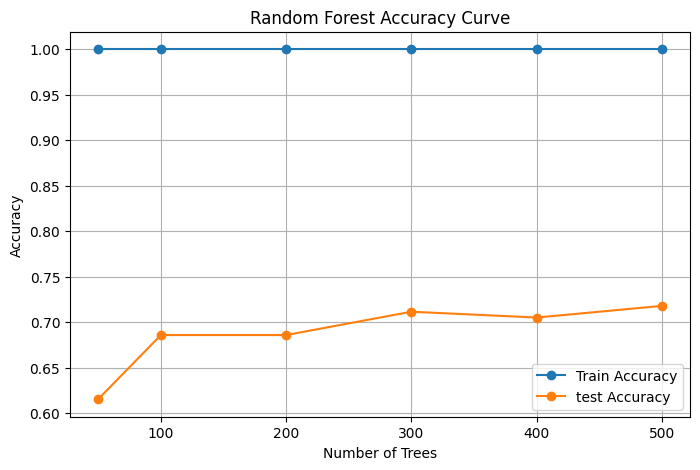

In [28]:
plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, train_acc, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, val_acc, marker='o', label='test Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()


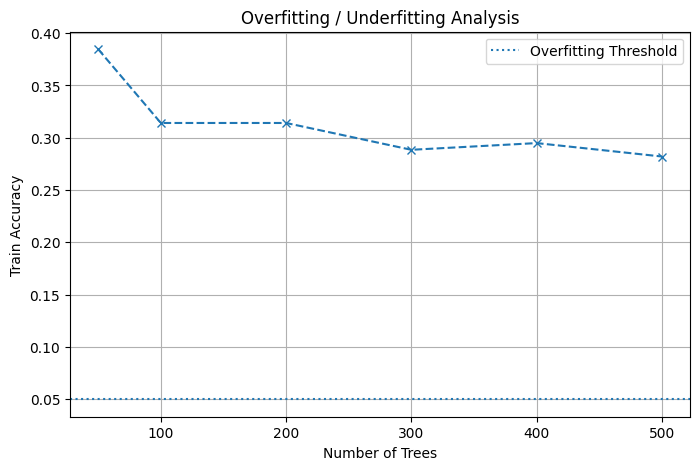

In [29]:
gap = np.array(train_acc) - np.array(val_acc)

plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, gap, marker='x', linestyle='--')
plt.axhline(0.05, linestyle=':', label='Overfitting Threshold')
plt.xlabel('Number of Trees')
plt.ylabel('Train Accuracy')
plt.title('Overfitting / Underfitting Analysis')
plt.legend()
plt.grid(True)
plt.show()


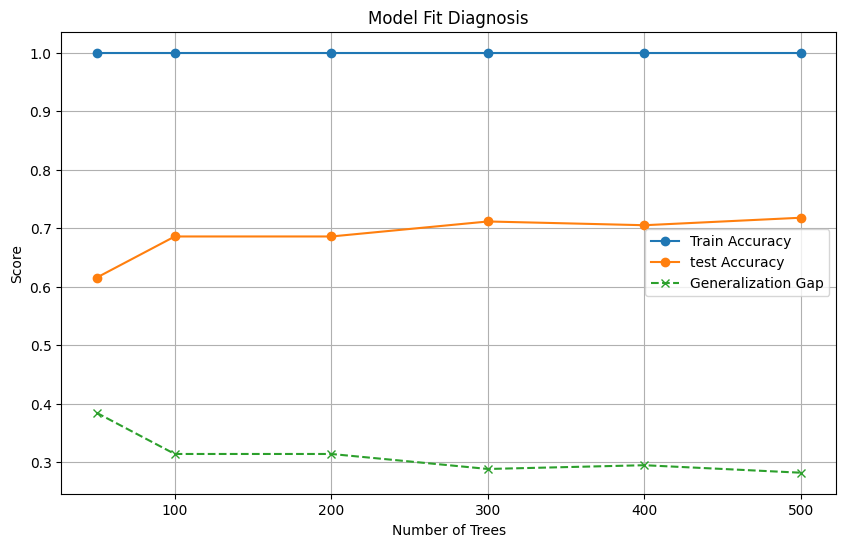

In [30]:
plt.figure(figsize=(10,6))
plt.plot(n_estimators_range, train_acc, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, val_acc, marker='o', label='test Accuracy')
plt.plot(n_estimators_range, gap, marker='x', linestyle='--', label='Generalization Gap')
plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Model Fit Diagnosis')
plt.legend()
plt.grid(True)
plt.show()

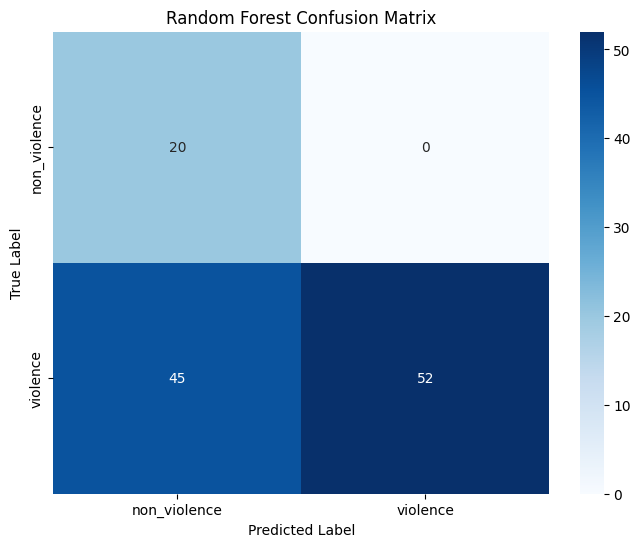

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, test_pred)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
